In [1]:
import sys
sys.path.insert(1, '/Users/linusrandud/Documents/UoM/ERP/MscDissertation/Deep-Opt')

In [2]:
import torch

from COProblems.MKP import MKP
from COProblems.QUBO import QUBO
from Models.DOAE import DOAE
from OptimAE import OptimAEHandler

In [3]:
import wandb
import matplotlib.pyplot as plt

In [4]:
# Initialize device
device = torch.device("cpu")
print(device)

# Define the file path and problem type
file_paths = ['../data/qubo/bqp100.txt']
problem_type = 'QUBO'
use_wandb = True  # Set to True if using Weights & Biases

cpu


In [5]:
# Parameters
params = {
    'change_tolerance': 100,
    'problem_size': 100,
    'pop_size': 1000,
    'dropout_prob': 0.2,
    'l1_coef': 0.0001,
    'l2_coef': 0.0001,
    'learning_rate': 0.002,
    'max_depth': 6,
    'compression_ratio': 0.8,
    'problem_instance_id': 0,
    'deepest_only': True,
    'encode': True,
    'repair_solutions': True,
    'patience': 3,  # Number of iterations to wait
    'delta_mean_population': 0.1  # Threshold for mean population change
}

# Initialize problem
if problem_type == 'QUBO':
    problem = QUBO(file_paths[0], params['problem_instance_id'], device)
elif problem_type == 'MKP':
    problem = MKP(file_paths[0], file_paths[1], params['problem_instance_id'], device)
else:
    raise ValueError("Unsupported problem type")

# Unpack parameters
change_tolerance = params['change_tolerance']
problem_size = params['problem_size']
pop_size = params['pop_size']
dropout_prob = params['dropout_prob']
l1_coef = params['l1_coef']
l2_coef = params['l2_coef']
lr = params['learning_rate']
max_depth = params['max_depth']
compression_ratio = params['compression_ratio']
hidden_size = problem_size

# Initialize model and handler
model = DOAE(problem_size, dropout_prob, device)
handler = OptimAEHandler(model, problem, device)

if use_wandb:
    wandb.init(project="Deep Optimization", tags=[problem_type])
    wandb.config.update(params)
    wandb.log_artifact(file_paths[0], type='dataset')
    if problem_type == 'MKP':
        wandb.log_artifact(file_paths[1], type='dataset')

# Generate initial population
population, fitnesses = handler.generate_population(pop_size)
population, fitnesses, _, _ = handler.hilldescent(population, fitnesses, change_tolerance)
handler.print_statistics(fitnesses)

total_eval = 0
depth = 0

# Store metrics for custom plotting
mean_fitnesses = []
max_fitnesses = []
total_evaluations = []
mean_fitness_changes = []

while True:
    if depth < max_depth:
        print("Adding layer")
        hidden_size = round(hidden_size * compression_ratio)
        model.transition(hidden_size)
        depth += 1
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
    
    print("Learning from population")
    handler.learn_from_population(population, optimizer, l1_coef=l1_coef, batch_size=pop_size)
    
    print("Optimising population")
    population, fitnesses, evaluations, done = handler.optimise_solutions(
        population, fitnesses, change_tolerance, encode=params['encode'], repair_solutions=params['repair_solutions'], deepest_only=params['deepest_only']
    )
    handler.print_statistics(fitnesses)

    mean_fitness = fitnesses.mean().item()
    max_fitness = fitnesses.max().item()
    total_eval += evaluations

    mean_fitnesses.append(mean_fitness)
    max_fitnesses.append(max_fitness)
    total_evaluations.append(total_eval)

    if use_wandb:
        wandb.log({
            "mean_fitness": mean_fitness,
            "max_fitness": max_fitness,
            "total_eval": total_eval,
            "depth": depth
        })

    print(f"Evaluations: {total_eval}")
    
    if len(mean_fitnesses) > 1:
        mean_fitness_change = abs(mean_fitnesses[-1] - mean_fitnesses[-2])
        mean_fitness_changes.append(mean_fitness_change)
        
        if len(mean_fitness_changes) >= params['patience']:
            recent_changes = mean_fitness_changes[-params['patience']:]
            if all(change < params['delta_mean_population'] for change in recent_changes):
                print(f"Stopping early due to no significant change in mean fitness over the last {params['patience']} iterations.")
                break
    
    if done:
        print(f"Optimum solution found.")
        break

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Instance has been loaded


wandb: Currently logged in as: linusrd. Use `wandb login --relogin` to force relogin


Max pop fitness: -10084.0, Mean pop fitness : -11914.7763671875
Adding layer
Learning from population
Optimising population
Max pop fitness: 4405.0, Mean pop fitness : 2693.491943359375
Evaluations: 371188
Adding layer
Learning from population
Optimising population
Max pop fitness: 5862.0, Mean pop fitness : 4778.08984375
Evaluations: 679250
Adding layer
Learning from population
Optimising population
Max pop fitness: 6402.0, Mean pop fitness : 5435.01904296875
Evaluations: 875392
Adding layer
Learning from population
Optimising population
Max pop fitness: 6416.0, Mean pop fitness : 5575.705078125
Evaluations: 1007744
Adding layer
Learning from population
Optimising population
Max pop fitness: 6416.0, Mean pop fitness : 5609.26416015625
Evaluations: 1114113
Adding layer
Learning from population
Optimising population
Max pop fitness: 6416.0, Mean pop fitness : 5656.43212890625
Evaluations: 1222343
Learning from population
Optimising population
Max pop fitness: 6416.0, Mean pop fitness : 

depth,▁▂▄▅▇██████████████
max_fitness,▁▆▇████████████████
mean_fitness,▁▆▇▇███████████████
total_eval,▁▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
depth,6
max_fitness,6556.0
mean_fitness,5817.95898
total_eval,2550575


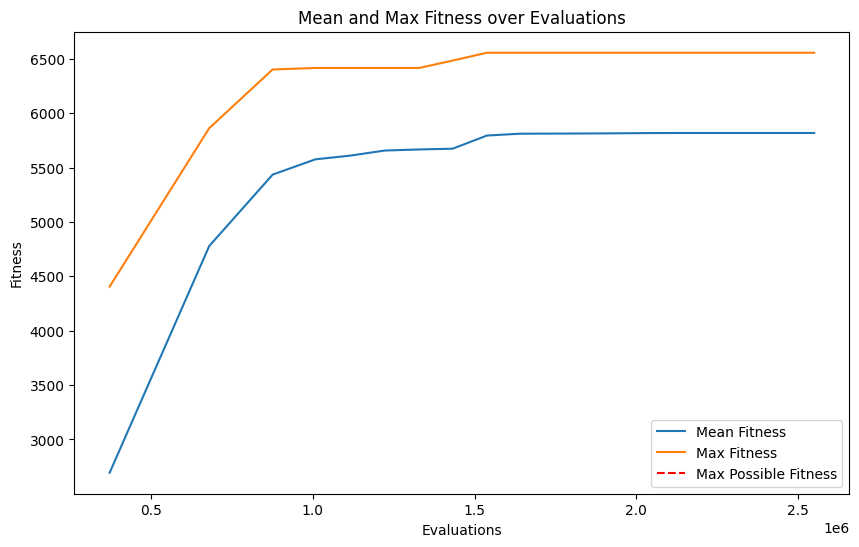

In [6]:
# Custom plot
plt.figure(figsize=(10, 6))
plt.plot(total_evaluations, mean_fitnesses, label='Mean Fitness')
plt.plot(total_evaluations, max_fitnesses, label='Max Fitness')
plt.axhline(y=problem.max_fitness, color='r', linestyle='--', label='Max Possible Fitness')
plt.xlabel('Evaluations')
plt.ylabel('Fitness')
plt.title('Mean and Max Fitness over Evaluations')
plt.legend()

# Save plot to W&B
wandb.log({"fitness_plot": wandb.Image(plt)})

# Finish the W&B run
wandb.finish()